* **기후정보학및실습** HW8
조선아(2173112)

Take the daily 500-hPa geopotential height over the Northern
Hemisphere in 2000-2009 during October-March.
- Compute and plot the standard deviation at each grid point.
- Low-pass filter the daily 500-hPa geopotential height field for
T > 30 days and plot its the standard deviation.
- High-pass filter the daily 500-hPa geopotential height field for
T < 10 days and plot its the standard deviation.

In [ ]:
# 라이브러리 불러오기
!pip install cartopy

import xarray as xr
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point

In [ ]:
base_url = 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/Dailies/pressure/hgt.' # NCEP Reanalysis v2 사용

datasets = []
for year in range(2000, 2010): # 2000-2009 데이터 불러오기
    url = f"{base_url}{year}.nc"
    urllib.request.urlretrieve(url, f'hgt_{year}.nc')
    ds = xr.open_dataset(f'hgt_{year}.nc')['hgt'].sel(level=500) # 500hPa 데이터 선택 후 저장
    datasets.append(ds)

hgt500 = xr.concat(datasets, dim='time') # 하나의 데이터로 합하기
hgt500_NH_winter = hgt500.sel(time=hgt500['time.month'].isin([10, 11, 12, 1, 2, 3])) # 북반구 겨울철 데이터 선택
hgt500_clim = hgt500_NH_winter.groupby('time.month').mean('time') # Climatology 제거
hgt500_anom = hgt500_NH_winter.groupby('time.month') - hgt500_clim

In [ ]:
# lanczos filter: calculating weights
# source: https://github.com/liv0505/Lanczos-Filter/blob/master/lanczosbp.py

def lanczos_lowpass_weights(cutoff, window):
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = (nwts -1) // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def lanczos_highpass_weights(cutoff, window):
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = (nwts -1) // 2
    w[n] = 1. - 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = - np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

# lanczos filter를 적용하고 데이터의 std를 구하는 함수 정의
def apply_lanczos_filter_and_std(data, weights, window_dim='window'):
    def apply_lanczos_filter(data, weights):
        filtered_data = np.apply_along_axis(lambda m: np.convolve(m, weights, mode='same'), axis=0, arr=data)
        # 위 함수로 연산한 weight를 np.convolve를 사용하여 데이터의 시간 차원에 적용하는 내부함수 정의
        # (연산 후 데이터의 길이가 같도록 설정하여, 일부 데이터 손실이 있을 수 있음)
        return filtered_data

    # 데이터의 시간 차원에 apply_lanczos_filter 함수를 적용
    # 메모리 문제를 방지하기 위해 dask를 사용하여 vectorized 연산을 수행
    filtered_data = xr.apply_ufunc(
        apply_lanczos_filter,
        data,
        weights,
        input_core_dims=[['time'], [window_dim]],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[data.dtype]
    )

    # 필터링된 데이터의 표준편차 연산 후 리턴
    std_filtered = filtered_data.std(dim='time')

    return std_filtered

In [ ]:
# lanczos filter parameter 정의

cutoff_low = 30 # days
cutoff_high = 10 # days
sampling_interval = 1 # day
cutoff_f_low = 1 / cutoff_low # frequency 연산 (역수)
cutoff_f_high = 1 / cutoff_high
window = 121 # 홀수로 선택
weights_low = lanczos_lowpass_weights(cutoff_f_low, window) # lowpass filter weight 연산
weights_high = lanczos_highpass_weights(cutoff_f_high, window) # highpass filter weight 연산

# 필터 적용
std_dev = hgt500_anom.std(dim='time') # (a) Total data 표준편차
lowpass = apply_lanczos_filter_and_std(hgt500_anom, weights_low, window_dim='window') # (b) low-pass data 표준편차
highpass = apply_lanczos_filter_and_std(hgt500_anom, weights_high, window_dim='window') # (c) high-pass data 표준편차

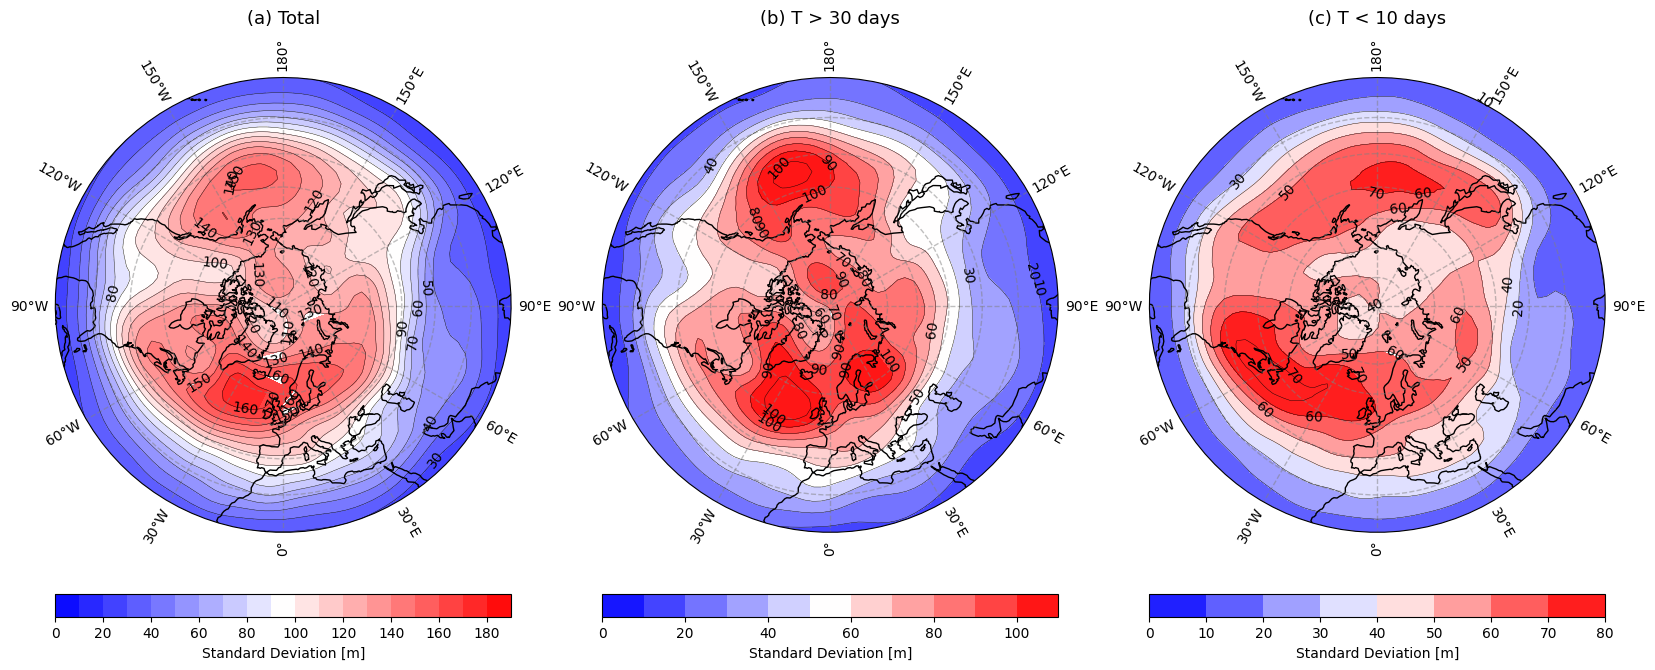

In [ ]:
# 북반구 20N-90N 그림을 그리는 함수 정의
def plot_data(ax, data, label, levels, lon_mod, lon, lat, title):
    # 북반구 20N 이상으로 위도 범위를 설정하고, 설정한 범위에 대해 위경도선 그리기
    ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                 xlocs=range(-180, 171, 30), ylocs=[],
                 color='gray', alpha=0.5, linestyle='--', zorder=10)
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1,
                 xlocs=[], ylocs=None,
                 color='gray', alpha=0.5, linestyle='--', zorder=10)

    # filled contour map 그리기
    cf = ax.contourf(lon_mod, lat, data, levels=levels, cmap='bwr', transform=ccrs.PlateCarree())
    # contour와 label 그리기
    ax.contour(lon_mod, lat, data, levels=levels, colors='k', transform=ccrs.PlateCarree(), linewidths=0.3)
    ax.clabel(cf, inline=True, fontsize=10, fmt='%1.0f', colors='k')
    # 해안선 그리기
    ax.coastlines()

    # NorthPolarStereo projection의 사각형 맵에서 20N 위도를 따라 원 모양만 남기기
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes) # 정의한 원대로 boundary 설정
    # 소제목 설정
    ax.set_title(title, fontsize=13, pad=10)
    # 컬러바 설정
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label(label)

    return fig, ax

# 경도 0도의 연속적인 데이터를 위한 처리 (optional)
data1, lon_mod1 = add_cyclic_point(std_dev.values, coord=std_dev.coords['lon'])
data2, lon_mod2 = add_cyclic_point(lowpass.values, coord=lowpass.coords['lon'])
data3, lon_mod3 = add_cyclic_point(highpass.values, coord=highpass.coords['lon'])

# NorthPolarStereo projection 설정
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8),
                         subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0.0, true_scale_latitude=20.0)})

# 데이터 plot
fig, ax = plot_data(axes[0], data1, 'Standard Deviation [m]', np.arange(0, 200, 10), lon_mod1, std_dev.coords['lon'], std_dev.coords['lat'], '(a) Total')
fig, ax = plot_data(axes[1], data2, 'Standard Deviation [m]', np.arange(0, 120, 10), lon_mod2, lowpass.coords['lon'], lowpass.coords['lat'], '(b) T > 30 days')
fig, ax = plot_data(axes[2], data3, 'Standard Deviation [m]', np.arange(0, 90, 10), lon_mod3, highpass.coords['lon'], highpass.coords['lat'], '(c) T < 10 days')

plt.show()

* Climatology를 제거하였으며, colorbar range는 example figure와 동일하게 설정하였다.
* (a)와 (b)는 공간 패턴이 유사하나, 표준편차의 크기는 (b)가 작다. 전체 대기의 변동성을 대부분 북극진동과 같은 30일보다 긴 변동성이 설명하고 있다.
* (c)는 (a), (b)와 공간 패턴이 다른 편이다. 이는 전체 대기의 변동성 중 날씨와 경압불안정 등의 작은 부분을 설명한다.
* 이처럼, 여러 개의 시간 규모를 가지는 데이터로 필터링을 수행하면 서로 다른 정보를 얻을 수 있다.

